In [14]:
import yfinance as yf
import GetOldTweets3 as got
import requests
import pytrends
from ta import add_all_ta_features
import praw
import pandas as pd
import os
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import keras
from io import StringIO
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
import numpy as np

In [9]:
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AMZN', 'GOOG', 'NVDA']

news_tables = {}
for ticker in tickers:
    url = finviz_url + ticker

    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)

    html = BeautifulSoup(response, features='html.parser')
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

parsed_data = []

for ticker, news_table in news_tables.items():

    for row in news_table.findAll('tr'):
   
        title = row.a.text
        date_data = re.split(r'\s+', row.td.text.strip())
 
        if len(date_data) == 1:
            time = date_data[0]
        else:
            if date_data[0] == 'Today':
                date = datetime.now().strftime('%b-%d-%y')
            else:
                date = date_data[0]
            time = date_data[1]

        parsed_data.append([ticker, date, time, title])

df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])

In [10]:
vader = SentimentIntensityAnalyzer()

f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df['title'].apply(f)

df['date'] = pd.to_datetime(df.date).dt.date

C:\Users\razva\AppData\Local\Temp\ipykernel_13184\3340248726.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df.date).dt.date


<Figure size 1000x800 with 0 Axes>

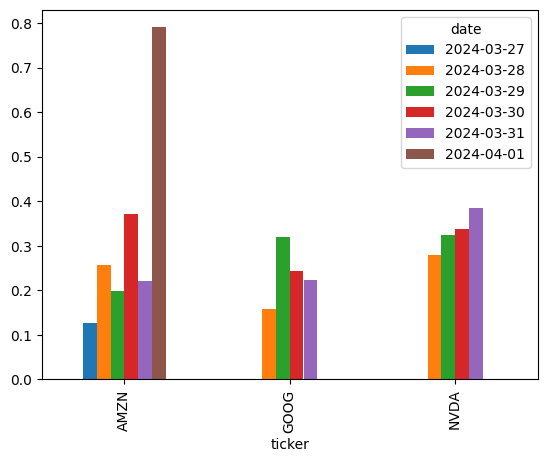

In [11]:
plt.figure(figsize=(10,8))
mean_df = df.groupby(['ticker', 'date']).mean(numeric_only=True).unstack()
mean_df = mean_df.xs('compound', axis="columns")
mean_df.plot(kind='bar')
plt.show()

In [12]:
AMZN = yf.Ticker("AMZN")
AMZN = AMZN.history(start='2020-01-01',end='2024-03-27')
amzn = AMZN[['Close', 'Volume']]
amzn.index = amzn.index.tz_localize(None)
sentiment_transposed = mean_df.T
sentiment_transposed.index = pd.to_datetime(sentiment_transposed.index)

# Merge DataFrames
merged_df = pd.merge(amzn, sentiment_transposed[['AMZN']], left_index=True, right_index=True, how='left')
merged_df = merged_df.rename(columns={'AMZN': 'Sentiment'})
merged_df['Sentiment'] = merged_df['Sentiment'].fillna(0)
merged_df=merged_df[['Close','Sentiment']]
display(merged_df)

,Close,Sentiment
Date,,
2020-01-02,94.900497,0.0
2020-01-03,93.748497,0.0
2020-01-06,95.143997,0.0
2020-01-07,95.343002,0.0
2020-01-08,94.598503,0.0
...,...,...
2024-03-20,178.149994,0.0
2024-03-21,178.149994,0.0
2024-03-22,178.869995,0.0


In [15]:
sc = MinMaxScaler(feature_range=(0,1))
split_idx = int(len(merged_df) * 0.8)

train_df = merged_df.iloc[:split_idx]
test_df = merged_df.iloc[split_idx:]

training_set_scaled = sc.fit_transform(train_df)

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [16]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=10,batch_size=32)

C:\Users\razva\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.1605
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0200
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0142
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0132
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0114
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0116
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0127
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0108
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0109
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0104


In [17]:
dataset_total = merged_df
inputs = dataset_total[len(dataset_total) - len(test_df) - 60:].values
#inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 76):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = model.predict(X_test)
#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Create a temporary array with the correct shape expected by the scaler
temp_array = np.zeros((predicted_stock_price.shape[0], 2))  # Shape (16, 2) to match the scaler

# Place the predicted stock prices into the first column of the temporary array
temp_array[:, 0] = predicted_stock_price.ravel()  # Assuming predictions correspond to the 'Close' prices

# Perform the inverse transformation on the adjusted array
inverse_transformed_array = sc.inverse_transform(temp_array)

# Extract the inverse transformed 'Close' prices, now correctly scaled
corrected_predicted_stock_price = inverse_transformed_array[:, 0]

# corrected_predicted_stock_price now contains the 'Close' prices after inverse transformation
predicted_stock_price = corrected_predicted_stock_price

real_stock_price = test_df['Close'].values

C:\Users\razva\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


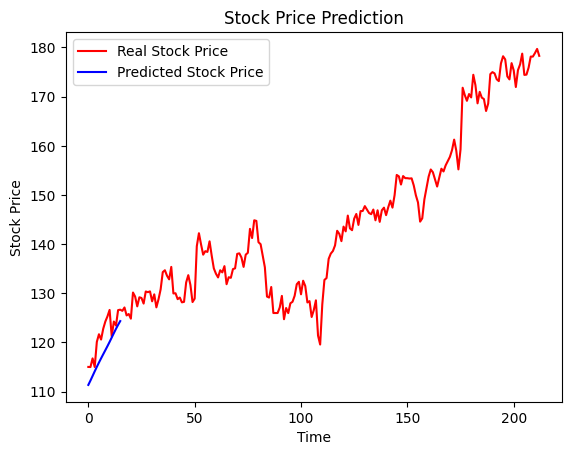

In [18]:
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()